In [70]:
import cv2 as cv
import argparse
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
from heapq import nlargest
import matplotlib.patches as mpatches
from scipy.stats import kurtosis, skew

def TrataImagem(src,visual,verbose,soildata):
    """Author: Ellen Giacometti
    CRIADO EM: 21/12/2018
    ÚLTIMA ATUALIZAÇÃO: 05/02/2019
    DESC: Código que recebe uma imagem e extrai os Atributos do limão contido nela"""
    """ LENDO IMAGEM """
    # Lendo Imagem
    img = src#cv.imread(src)
    # Convertendo canal HSV
    imgHSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Separando o canal de saturação
    h, s, v = cv.split(imgHSV)
    """ EXIBINDO CANAIS """
    if visual == 1:
        fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
        ax1.axis('off')
        ax1.imshow(h, cmap=plt.cm.gray)
        ax1.set_title(' h IMAGE')
        ax2.axis('off')
        ax2.imshow(s, cmap=plt.cm.gray)
        ax2.set_title('s IMAGE')
        ax3.axis('off')
        ax3.imshow(v, cmap=plt.cm.gray)
        ax3.set_title('v  IMAGE')
        plt.show()
    """ PROCESSAMENTO DA IMAGEM """
     # Filtro para borrar
    s_Blur = cv.blur(s,(5,5))
    # Binarizando a imagem
    _, s_Thresh = cv.threshold(s_Blur,50,255,cv.THRESH_BINARY)
    # Morfologia tamanho do elemento estrutural
    block_size = 30
    kernel = np.ones((block_size, block_size), np.uint8)
    # Executando Dilation e Closing
    s_Closing = cv.morphologyEx(s_Thresh, cv.MORPH_CLOSE, kernel)
    # Resultado da Máscara em RGB
    s_Result = cv.bitwise_and(cv.cvtColor(img, cv.COLOR_BGR2RGB), cv.cvtColor(img, cv.COLOR_BGR2RGB), mask=s_Closing)
    """ PRINTANDO IMAGENS DO PROCESSO   """
    if visual==1:
        fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
        ax1.axis('off')
        ax1.imshow(s_Blur, cmap=plt.cm.gray)
        ax1.set_title('s_Blur ')
        ax2.axis('off')
        ax2.imshow(s_Thresh, cmap=plt.cm.gray)
        ax2.set_title('s_Thresh')
        ax3.axis('off')
        ax3.imshow(s_Closing, cmap=plt.cm.gray)
        ax3.set_title('s_Closing')
        ax4.axis('off')
        ax4.imshow(s_Result, cmap=plt.cm.gray)
        ax4.set_title('s_Result')
        plt.show()
    """ CRIANDO ROI """
    # Declarando variável BoundingBox
    BoundingBox = np.zeros_like(img)
    BoundingBox[s_Closing == 255] = img[s_Closing == 255]
    # Definindo pontos para corte
    (x, y) = np.where(s_Closing == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    # Desprezando a imagem ao redor dos pontos
    BoundingBox = BoundingBox[topx:bottomx + 1, topy:bottomy + 1]
    # Convertendo para cinza
    gray_BoundingBox = cv.cvtColor(BoundingBox, cv.COLOR_RGB2GRAY)
    """ CONTORNO OPENCV """
    # Capturando contornos
    _, contornosCV, _ = cv.findContours(gray_BoundingBox, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    # Adquirindo o número de contornos encontrados
    tamanho_contornoCV = len(contornosCV)
    # Declarando um array para armazenar o tamanho de cada contorno
    tamanhoCV = np.empty([tamanho_contornoCV])
    for i in range(tamanho_contornoCV):
        # Adquirindo o tamanho de cada contorno encontrado
        tamanhoCV[i] = contornosCV[i].shape[0]
    # Detectando os N maiores contornos e seus indices, alterando N , os N maiores contornos serão armazenados.
    maioresCV = nlargest(1, enumerate(tamanhoCV), key=lambda a: a[1])

    """ MEDIDAS LIMÃO - CONTORNO ÚTIL   """
    contorno_util=contornosCV[maioresCV[0][0]]
    M = cv.moments(contorno_util)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    """ MEDIDAS CIRCUNFERÊNCIA CIRCUNSCRITA """
    ((x, y), raio) = cv.minEnclosingCircle(contorno_util)
    centroide = (int(x), int(y))
    """ HISTOGRAMA DO CANAL H   """
    # Mudando os canais da ROI
    HSV_BoundingBox = cv.cvtColor(BoundingBox, cv.COLOR_BGR2HSV)
    # Separando o canal de saturação
    h_BoundingBox, _, _ = cv.split(HSV_BoundingBox)
    hist = cv.calcHist([h], [0], s_Closing, [256], [0, 256])
    hist = list(map(float, hist[0:255][:]))

    """ TEXTURA:KURTOSIS & SKEWNESS """
    texture_Kurt = kurtosis(gray_BoundingBox, axis=None)
    texture_Skew = skew(gray_BoundingBox, axis=None)
    """TEXTURA: GLCM"""
    glcm = greycomatrix(gray_BoundingBox, [5], [0], 256, symmetric=True, normed=True)
    dissimilarity= greycoprops(glcm, 'dissimilarity')[0, 0]
    correlation= greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm,'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    contrast= greycoprops(glcm, 'contrast')[0, 0]
    ASM = greycoprops(glcm,'ASM')[0,0]

    """DEBUG VERSION """
    if(visual==1):
        """DESENHANDO O CONTORNO E A CIRCUNFERÊNCIA"""
        # fig2, ax = plt.subplots()
        # ax.imshow(gray_BoundingBox, interpolation='nearest', cmap=plt.cm.gray)
        # for n, contornoCV in enumerate(contornosCV):
        #     if (n in (np.transpose(np.asanyarray(maioresCV))[:])):
        #         ax.plot(contornoCV[:, 0][:, 0], contornoCV[:, 0][:, 1], '-b', linewidth=2)
        #         circulo = mpatches.Circle((x, y), raio, fill=False, edgecolor='red', linewidth=2)
        #         ax.add_patch(circulo)
        # plt.show()
        """DESENHANDO HISTOGRAMA"""
        # plt.figure()
        # plt.title("H Histogram")
        # plt.xlabel("Bins")
        # plt.ylabel("# of Pixels")
        # plt.plot(hist)
        # plt.xlim([0, 256])
        # plt.show()

    """GERANDO RELATÓRIO """
    if verbose==1:
        print("\n---~ INFORMAÇÕES - CONTORNO DO LIMÃO ~---")
        print("Número de Contornos Encontrados na Imagem:", tamanho_contornoCV)
        print("Perímetro:", maioresCV[0][1])
        print("Centróide:(", cx, ",", cy, ")")
        print("\n---~ SIZE & SHAPE - CIRCUNFERÊNCIA ~---")
        print("Raio:", raio, "\nCentro:", centroide)
        print("\n---~ TEXTURE - KURTOSIS SKEWNESS~---")
        print("Kurtosis:",texture_Kurt,"\nSkewness:",texture_Skew)
        print("\n---~ TEXTURE - GLCM~---")
        print("Dissimilarity:",dissimilarity)
        print("Correlation:",correlation)
        print("Homogeneity:", homogeneity)
        print("Energy:", energy)
        print("Contrast:", contrast)
        print("ASM:", ASM)


    #soildata=[Alum,Ca,K,Mg,N,P,pH,C]
    return [hist, texture_Kurt, texture_Skew, soildata]

In [51]:
import cv2 as cv
import numpy as np
import pandas as pd
import gdal

In [8]:
GeoMatrix = gdal.Open("0074_stitch2_modificado.tif")
def world2pixel(geoMatrix, posX, posY):

    xoffset, px_w, rot1, yoffset, px_h, rot2 = geoMatrix.GetGeoTransform()

    x = int((posX - xoffset) / px_w)
    y = int((posY - yoffset) / rot2)

    return x, y

In [81]:
data = pd.read_csv('Sensores.csv',delimiter=';',encoding="ISO-8859-1")
data.head()

,X,Y,ALUMÍNIO,Calcio,Potássio,Magnésio,Nitrogênio,Fósforo,pH,Carbono
0,-4861828.76,-2602693.37,0.02,0.94,15,0.28,0.03,17.41,5.50,3.10
1,-4861838.52,-2602690.34,0.00,0.50,12,0.20,0.01,11.42,6.35,1.30
2,-4861849.31,-2602684.98,0.00,1.22,22,0.44,0.03,18.16,6.19,3.76
3,-4861858.19,-2602680.36,0.00,1.53,50,0.63,0.06,24.63,5.93,5.38
4,-4861868.20,-2602676.63,0.00,1.44,19,0.54,0.05,21.09,5.77,4.90


In [84]:
df=pd.DataFrame(data)

In [85]:
coordx=np.array(df['X'])
coordy=np.array(df['Y'])

In [86]:
pixels=list() 
listx=list() 
listy=list()
for i in range(len(coordx)):
    x, y = world2pixel(GeoMatrix,coordx[i],coordy[i])
    pixels.append([x,y])
    listx.append(x)
    listy.append(y)

In [87]:
len(pixels)

192

In [43]:
df['px']=np.array(listx)
df['py']=np.array(listy)

In [88]:
df.to_csv('Sensores_pixel.csv', sep=';')

In [58]:
np.array(df.iloc[0,2:10])

array([ 0.02,  0.94, 15.  ,  0.28,  0.03, 17.41,  5.5 ,  3.1 ])

In [89]:
img = cv.imread('0074_stitch2_modificado.tif')
Features=list()
space=10
cont=0
for i in range(len(coordx)):
    try:
        corte=img[listx[i]-space:listx[i]+space,listy[i]-space:listy[i]+space]
        hist, texture_Kurt, texture_Skew, soildata = TrataImagem(corte,visual=0,verbose=0,soildata=np.array(df.iloc[i,2:10]))
        Features.append([hist, texture_Kurt, texture_Skew, soildata])
    except:
        print("Deu merda!")
        cont=cont+1

Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!
Deu merda!


In [90]:
cont

50

In [93]:
len(Features)

142

In [92]:
len(coordx)

192

<function matplotlib.pyplot.show(*args, **kw)>

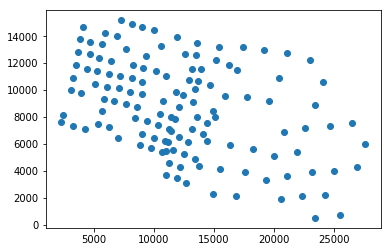

In [79]:
import matplotlib.pyplot as plt
plt.plot(listy, listx,'o')
plt.show

In [108]:
v=np.random.randint(0,142,43)
teste=[]
for i in v:
    if i not in teste:
        teste.append(i)
    else:
        while i in teste:
            i=i+1
            if i==141: 
                i=0

In [113]:
Features[np.array(teste)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [115]:
np.array(teste)

array([135,  21,  27,  14,  64,  76,  26, 122,  74, 120, 113,  96,  35,
       101,   9,  16,  88,  62,  11,  68,   6,  65,  30,  38,  47, 103,
        93,  92,  46,  91, 107,   8,  24,  20,  54, 130, 119, 108,  94])

In [121]:
FeaturesTest=[]
FeaturesTrain=[]
for i in range(len(Features)):
    if i in teste:
        FeaturesTest.append(Features[i])
    else:
        FeaturesTrain.append(Features[i])

In [123]:
len(FeaturesTest)

39

In [124]:
len(FeaturesTrain)

103

# Trainamento

In [126]:
from sklearn.ensemble import RandomForestClassifier
from numpy.core.multiarray import ndarray
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

class InternalRandomForest(object):
    """
    Random Forest Training Class using previously preparated dataset.
    """

    @staticmethod
    def modeltrain(features: ndarray, target: ndarray, number_trees: int) -> RandomForestClassifier:
        """
        Method to create and fit a new trained RF model by a known number of trees
        Args:
            features                         (ndarray): Array of dataset features (samples).
            target                           (ndarray): Array of dataset targets (species).
            number_trees                     (int): Number of trees to train classifier.
        Returns:
            trained_model                    (object): Trained RandomForestClassifier object.
        """

        trained_model = RandomForestClassifier(number_trees)
        trained_model.fit(features, target)

        return trained_model

    @staticmethod
    def getbestnumberoftrees(features: ndarray, target: ndarray, limit:int) -> tuple:
        """
        Method to know the number of trees that generate the best training
        using the ACCURACY method of Random Forest
        Args:
            features                         (ndarray): Array of dataset features (samples).
            target                           (ndarray): Array of dataset targets (species).
            limit                            (int): Limit of number of trees to train and obtain best number trees.
        Returns:
            bestNumberTrees                  (int): Best number of trees in training.
            accuracyList                     (list): List of accuracies obtained during training sets.
            best_model                       (object): Model trained with best number of trees.
        """

        # Defining the initial accuracy value to compare with different number of trees in training
        accuracy = 0
        accuracyList = []

        for n in range(1, limit+1, 1):
            # Training
            trained_model = InternalRandomForest.modeltrain(features, target, n)

            # Calculating the percentual accuracy of the training
            accuracy_t = accuracy_score(target, trained_model.predict(features), normalize=True)

            # Build accuracy array for this set of number of trees
            accuracyList.append(accuracy_t)

            # Verifying if the current training is better than the last one
            if accuracy_t > accuracy:
                bestNumberTrees = n
                accuracy = accuracy_t

        # Obtain best trained model
        best_model = InternalRandomForest.modeltrain(features, target, bestNumberTrees)

        return bestNumberTrees, accuracyList, best_model

    @staticmethod
    def gethitscm(features: ndarray, target: ndarray, trained_model) -> tuple:
        """
        Method to know the global hits and the hits of the true objects using
        the Confusion Matrix
        Args:
            features                         (ndarray): Array of dataset features (samples).
            target                           (ndarray): Array of dataset targets (species).
            trained_model                    (object): Trained RandomForestClassifier object.
        Returns:
            global_hits                      (list): Global hits in CM.
            true_hits                        (list): True hits in CM.
        """
        # Generating the Confusion Matrix
        predictions = trained_model.predict(features)

        cm = confusion_matrix(target, predictions)

        # Calculating the global hits
        global_hits = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[1, 0] + cm[0, 1])
        true_hits = cm[1, 1] / (cm[1, 0] + cm[1, 1])

        return (cm, global_hits, true_hits)

    @staticmethod
    def getaccuracy(features: ndarray, target: ndarray, trained_model) -> float:
        """
        Method to get accuracy from a previously trained model, applying features and samples from test dataset.
        Args:
            features                         (ndarray): Array of test dataset features (samples).
            target                           (ndarray): Array of test dataset targets (species).
            trained_model                    (object): Trained RandomForestClassifier object.
        Returns:
            accuracy                         (float): Accuracy of Test
        """
        predictions = trained_model.predict(features)

        accuracy = accuracy_score(target, predictions, normalize=True)

        return accuracy

In [127]:
import time
from sys import path, platform
from os import getcwd
from numpy import load
from numpy import arange
from numpy import linspace
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [128]:
rf = InternalRandomForest()

In [130]:
quadro=pd.DataFrame(FeaturesTrain)
quadro.head()

,0,1,2,3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.101072,-0.921257,"[0.0, 1.22, 22.0, 0.44, 0.03, 18.16, 6.19, 3.76]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.589769,-0.124244,"[0.0, 1.53, 50.0, 0.63, 0.06, 24.63, 5.93, 5.38]"
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.210732,-0.570403,"[0.0, 1.44, 19.0, 0.54, 0.05, 21.09, 5.77, 4.9]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.574273,0.605160,"[0.0, 1.27, 48.0, 0.56, 0.04, 10.61, 6.34, 3.7]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.653816,0.121899,"[0.05, 0.54, 7.0, 0.15, 0.02, 6.38, 5.11, 3.16]"


In [228]:
#Al=0 Ca=1 K=2 Mg=3 N=4 P=5 pH=6 C=7

ind=0
t=[]
for i in range(len(quadro[3])):
    t.append(np.array(quadro[3])[i][ind])
targets=np.array(t).reshape(103,1)
a=np.array(quadro[0]).reshape(103,1)
b=np.array(quadro[1]).reshape(103,1)
c=np.array(quadro[2]).reshape(103,1)
feat=np.hstack((a,b,c))

In [242]:
dfeat=dict(zip(np.array(range(103)),feat))
dtargets=dict(zip(np.array(range(103)),targets))

In [246]:
treeLimit = 5
bestNumberTrees, accuracy, bestModel = rf.getbestnumberoftrees(feat, targets, treeLimit)

ValueError: setting an array element with a sequence.